# Accessing higher energy states with Qiskit Pulse

## 2. Discriminating the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states <a id="discrim012"></a> 

Now that we have calibrated the $0, 1$ discriminator, we move on to exciting higher energy states. Specifically, we focus on exciting the $|2\rangle$ state and building a discriminator to classify $|0\rangle$, $|1\rangle$ and $2\rangle$ states from their respective IQ data points. The procedure for even higher states ($|3\rangle$, $|4\rangle$, etc.) should be similar, but we have not tested them explicitly.

The process for building the higher state discriminator is as follows:
1. Compute the $1\rightarrow2$ frequency.
2. Conduct a Rabi experiment to obtain the $\pi$ pulse amplitude for $1\rightarrow2$. To do this, we first apply a $0\rightarrow1$ $\pi$ pulse to get from the $|0\rangle$ to the $|1\rangle$ state. Then, we do a sweep of drive amplitudes at the $1\rightarrow2$ frequency obtained above.
3. Construct 3 schedules:\
    a. Zero schedule: just measure the ground state.\
    b. One schedule: apply a $0\rightarrow1$ $\pi$ pulse and measure.\
    c. Two schedule: apply a $0\rightarrow1$ $\pi$ pulse, then a $1\rightarrow2$ $\pi$ pulse and measure.
4. Separate the data from each schedule into training and testing sets and construct an LDA model for discrimination.

### 2A. Computing the 1->2 frequency <a id="freq12"></a>

The first step in our calibration is to compute the frequency needed to go from the $1\rightarrow2$ state. There are two methods to do this:
1. Do a frequency sweep from the ground state and apply very high power. If the applied power is large enough, two peaks should be observed. One at the $0\rightarrow1$ frequency found in section [1](#discrim01) and one at the $0\rightarrow2$ frequency. The $1\rightarrow2$ frequency can be obtained by taking the difference of the two. Unfortunately, for `ibmq_armonk`, the maximum drive power of $1.0$ is not sufficient to see this transition. Instead, we turn to the second method.
2. Excite the $|1\rangle$ state by applying a $0\rightarrow1$ $\pi$ pulse. Then perform the frequency sweep over excitations of the $|1\rangle$ state. A single peak should be observed at a frequency lower than the $0\rightarrow1$ frequency which corresponds to the $1\rightarrow2$ frequency.

#### 1->2 Frequency Sweep using the sideband method <a id="sideband12"></a>

We follow the second method described above. To drive the $0\rightarrow 1$ $\pi$ pulse, we require a local oscillator (LO) frequency given by the calibrated $0\rightarrow1$ frequency `cal_qubit_freq` (see construction of the Rabi $\pi$ pulse in section [1](#discrim01)). To sweep the range for the $1\rightarrow2$ frequency, however, we require varying the LO frequency. Unfortunately, the Pulse specification requires a single LO frequency per schedule. 

To resolve this, we set the LO frequency to `cal_qubit_freq` and multiply a sine function onto the $1\rightarrow2$ pulse at `freq-cal_qubit_freq`, where `freq` is the desired scan frequency. Applying the sinusoidal sideband, as it's known, enables us to change the LO frequency without manually setting it when assembling the program.

In [87]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform
from qiskit.tools.monitor import job_monitor

from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit.test.mock import FakeValencia

from utils import get_closest_multiple_of_16
from utils import get_job_data
from utils import fit_function
from utils import apply_sideband
from utils import create_excited_freq_sweep_program
from utils import baseline_remove

In [11]:
from qiskit import IBMQ
IBMQ.enable_account('a1e179011c9095c208f4168f632df8f6a85c77a56663a083106ff6b51f7e0946d743f8ab54b118a3249afe67a7dea34d3d57918a73d06733ae0fc75aa6964c04')
#IBMQ.load_account()
#IBMQ.active_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

IBMQAccountError: 'An IBM Quantum Experience account is already in use for the session.'

In [12]:
dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us  = 1.0e-6 # Microseconds
ns  = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
cal_qubit_freq = default_qubit_freq
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan  = pulse.MeasureChannel(qubit)
acq_chan   = pulse.AcquireChannel(qubit)

# default parameters taken from the x_gate_01.ipynb
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   #

# final result for the x_gate_pulse from x_gate_01.ipynb
pi_amp_01 = 0.1283062596553004
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

Qubit 0 has an estimated frequency of 4.971648972721859 GHz.


In [13]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    
    
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq, dt, drive_samples, cal_qubit_freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: cal_qubit_freq}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

We wrap the logic for assembling the program in a method and run our program.

The frequency sweep will go from 4.871648972721859 GHz to 5.071648972721859 GHz using 75 frequencies. The drive power is 0.5.


/Users/Eden/.local/lib/python3.7/site-packages/qiskit/pulse/schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments scale, label, channels are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


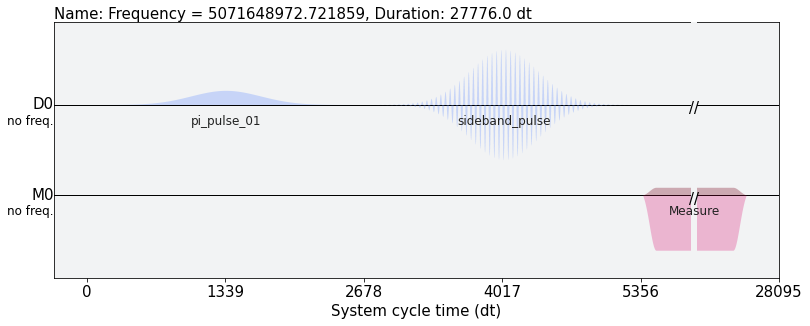

In [60]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
#excited_sweep_freqs = cal_qubit_freq + np.linspace(-800*MHz, -400*MHz, num_freqs) # OF: changed from (-400, 30)

excited_sweep_freqs = cal_qubit_freq + np.linspace(-100*MHz, 100*MHz, num_freqs)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.5)

# Plot an example schedule to make sure it's valid

In [61]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)

/Users/Eden/opt/anaconda3/envs/quantum-computing/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  """Entry point for launching an IPython kernel.


In [62]:
print(excited_freq_sweep_job.job_id())
job_monitor(excited_freq_sweep_job)

60fff609fa10e7ce23ea351f
Job Status: job has successfully run


In [64]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True, qubit=0)

/Users/Eden/opt/anaconda3/envs/quantum-computing/lib/python3.7/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


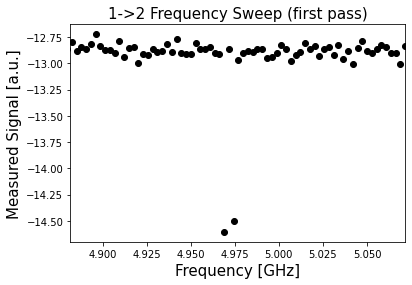

In [65]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

We see a maximum around $4.64$ GHz. There are a few spurious minima, but they are too large to be the $1\rightarrow2$ frequency. The maximum corresponds the $1\rightarrow2$ frequency. 

Using a relative maxima function, we compute the value of this point exactly. This gives an estimate for the $1\rightarrow2$ frequency.

In [66]:
# Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
def rel_maxima(freqs, output_data, height): 
    """
    Prints out relative maxima frequencies in output_data (can see peaks); height gives upper bound (abs val).
    Be sure to set the height properly or the peak will be ignored!
    Args:
        freqs (list): frequency list
        output_data (list): list of resulting signals
        height (float): upper bound (abs val) on a peak
    Returns:
        list: List containing relative maxima frequencies
    """
    peaks, _ = find_peaks(output_data, height)
    print("Freq. dips: ", freqs[peaks])
    return freqs[peaks]

In [67]:
rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), 10)

Freq. dips:  []


array([], dtype=float64)

In [69]:
maxima = rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), 10)
approx_12_freq = 4.975 * GHz

Freq. dips:  []


We now use the estimate obtained above to do a refined sweep (i.e., much smaller range). This will allow us to obtain a more accurate value for the $1\rightarrow2$ frequency. We sweep $20$ MHz in each direction.

The frequency sweep will go from 4.955 GHz to 4.995 GHz using 75 frequencies. The drive power is 0.3.


/Users/Eden/.local/lib/python3.7/site-packages/qiskit/pulse/schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments scale, label, channels are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


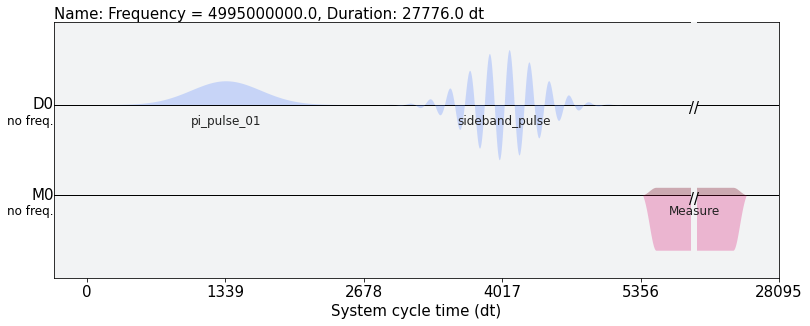

In [70]:
# smaller range refined sweep

num_freqs = 75
refined_excited_sweep_freqs = approx_12_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [91]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)

/Users/Eden/opt/anaconda3/envs/quantum-computing/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  """Entry point for launching an IPython kernel.


In [92]:
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

60fff90ca75cbf27bef99937
Job Status: job has successfully run


In [93]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True, qubit=qubit)

Let's plot and fit the refined signal, using the standard Lorentzian curve.

In [100]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.960*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

/Users/Eden/opt/anaconda3/envs/quantum-computing/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


/Users/Eden/opt/anaconda3/envs/quantum-computing/lib/python3.7/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


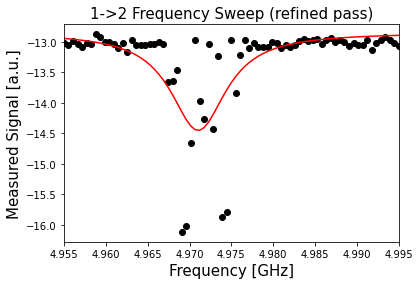

In [101]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [102]:
_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.9710405 GHz.


### 2B. 1->2 Rabi Experiment  <a id="rabi12"></a>

Now that we have a good estimate for the $1\rightarrow2$ frequency, we perform a Rabi experiment to obtain the $\pi$ pulse amplitude for the $1\rightarrow2$ transition. To do so, we apply a $0\rightarrow1$ $\pi$ pulse and then sweep over drive amplitudes at the $1\rightarrow2$ frequency (using the sideband method).

In [103]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [104]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq, dt=dt, drive_samples=drive_samples, cal_qubit_freq=cal_qubit_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [105]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [106]:
rabi_12_job = backend.run(rabi_12_expt_program)

/Users/Eden/opt/anaconda3/envs/quantum-computing/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  """Entry point for launching an IPython kernel.


In [107]:
print(rabi_12_job.job_id())
job_monitor(rabi_12_job)

60fff9dbfa10e772e5ea3554
Job Status: job has successfully run


In [108]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True, qubit=qubit)

We plot and fit our data as before.

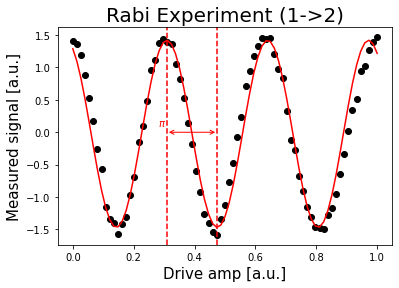

In [109]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_data, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [3, 0.5, 0.9, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [110]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.9710405 GHz.
Pi Amplitude (1->2) = 0.30887867284702064


With this information, we can define our $1\rightarrow2$ $\pi$ pulse (making sure to add a sideband at the $1\rightarrow2$ frequency).

In [112]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq, dt=dt, drive_samples=drive_samples, cal_qubit_freq=cal_qubit_freq)

## Constructing X $|1\rangle$ -> $|2\rangle$ Gate

In [113]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit.test.mock import FakeValencia

backend = FakeValencia()

with pulse.build(backend, name='x_12') as x_12:
    pulse.play(pi_pulse_12, pulse.drive_channel(0))

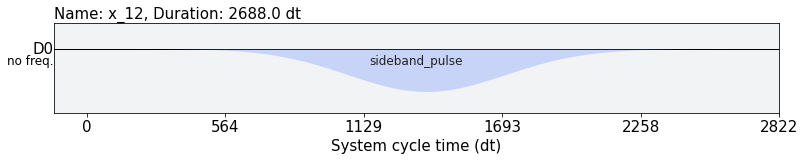

In [114]:
x_12.draw()

In [116]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

circ = QuantumCircuit(1, 1)
pulse_x12_gate = Gate('pulse_x12_gate', 1,[])
circ.append(pulse_x12_gate, [0])
circ.measure(0, 0)

circ.draw()

┌────────────────┐┌─┐
q_0: ┤ pulse_x12_gate ├┤M├
     └────────────────┘└╥┘
c: 1/═══════════════════╩═
                        0

In [117]:
with pulse.build(backend, name='pulse_x12') as pulse_x12_schedule:
    pulse.play(pi_pulse_12, pulse.drive_channel(0))

circ.add_calibration('pulse_x12_gate', [0], pulse_x12_schedule)

In [118]:
circ = transpile(circ, backend)
circ.draw(idle_wires=False)

NameError: name 'transpile' is not defined